In [1]:
import numpy as np
import scipy.interpolate
import torch
from matplotlib import pyplot as plt


def bd_metric(R1, PSNR1, R2, PSNR2, piecewise=0):
    lR1 = np.log(R1)
    lR2 = np.log(R2)

    PSNR1 = np.array(PSNR1)
    PSNR2 = np.array(PSNR2)

    # integration interval
    min_int = max(min(lR1), min(lR2))
    max_int = min(max(lR1), max(lR2))

    # find integral
    if piecewise == 0:
        p1 = np.polyfit(lR1, PSNR1, 3)
        p2 = np.polyfit(lR2, PSNR2, 3)

        p_int1 = np.polyint(p1)
        p_int2 = np.polyint(p2)

        int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
        int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)
    else:
        # See https://chromium.googlesource.com/webm/contributor-guide/+/master/scripts/visual_metrics.py
        lin = np.linspace(min_int, max_int, num=1000, retstep=True)
        interval = lin[1]
        samples = lin[0]
        v1 = scipy.interpolate.pchip_interpolate(np.sort(lR1), PSNR1[np.argsort(lR1)], samples)
        v2 = scipy.interpolate.pchip_interpolate(np.sort(lR2), PSNR2[np.argsort(lR2)], samples)
        # Calculate the integral using the trapezoid method on the samples.
        int1 = np.trapz(v1, dx=interval)
        int2 = np.trapz(v2, dx=interval)

    # find avg diff
    avg_diff = (int2 - int1) / (max_int - min_int)

    return avg_diff


def bd_rate(R1, PSNR1, R2, PSNR2, piecewise=0):
    lR1 = np.log(R1)
    lR2 = np.log(R2)

    # integration interval
    min_int = max(min(PSNR1), min(PSNR2))
    max_int = min(max(PSNR1), max(PSNR2))

    # find integral
    if piecewise == 0:
        p1 = np.polyfit(PSNR1, lR1, 3)
        p2 = np.polyfit(PSNR2, lR2, 3)

        p_int1 = np.polyint(p1)
        p_int2 = np.polyint(p2)

        int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
        int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)
    else:
        lin = np.linspace(min_int, max_int, num=1000, retstep=True)
        interval = lin[1]
        samples = lin[0]
        v1 = scipy.interpolate.pchip_interpolate(np.sort(PSNR1), lR1[np.argsort(PSNR1)], samples)
        v2 = scipy.interpolate.pchip_interpolate(np.sort(PSNR2), lR2[np.argsort(PSNR2)], samples)
        # Calculate the integral using the trapezoid method on the samples.
        int1 = np.trapz(v1, dx=interval)
        int2 = np.trapz(v2, dx=interval)

    # find avg diff
    avg_exp_diff = (int2 - int1) / (max_int - min_int)
    avg_diff = (np.exp(avg_exp_diff) - 1) * 100
    return avg_diff

In [2]:
import matplotlib


class Plot:
    def __init__(self, label):
        self.label = label

        self.fig, self.ax = plt.subplots(figsize=(30, 10))
        self.ax.ticklabel_format(style='plain')

        self.ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{int(x // 1000)} kbps"))

        matplotlib.rcParams.update({'font.size': 25})
        plt.grid(True)

    def plot_entries(self, entries, label="None", steps=1000, color='r'):
        bitrates = list(entries.keys())
        psnrs = list(entries.values())
        min_bitrate, max_bitrate = min(bitrates), max(bitrates)

        xs, interval = np.linspace(min_bitrate, max_bitrate, num=steps, retstep=True)
        ys = scipy.interpolate.pchip_interpolate(bitrates, psnrs, xs)

        self.ax.plot(xs, ys, label=label)
        self.ax.legend()
        for bitrate, psnr in entries.items():
            self.ax.scatter(bitrate, psnr, s=50, zorder=10, marker="o", facecolors='none', edgecolors=color)

        plt.xlabel("bitrate")
        plt.ylabel(self.label)

In [3]:
from pathlib import Path
from src.dataset.util.directory_operations import calculate_average_bitrate_in_directory, \
    calculate_average_metric_in_directory, calculate_average_metric_in_directory_for_model


def process_bd_rates(model_input_clips, dbf_sao_clips, models, save_name, metric_func):
    model_input_bitrates = [calculate_average_bitrate_in_directory(path) for path in model_input_clips]
    dbf_sao_bitrates = [calculate_average_bitrate_in_directory(path) for path in dbf_sao_clips]

    dbf_sao_metrics = [calculate_average_metric_in_directory(path, metric_func) for path in dbf_sao_clips]
    pred_metrics = [
        calculate_average_metric_in_directory_for_model(path, model.eval().cuda(), metric_func)
        for path, model in zip(model_input_clips, models)
    ]

    no_deblocking_metrics = [calculate_average_metric_in_directory(path, metric_func) for path in model_input_clips]
    print(pred_metrics)
    print(dbf_sao_metrics)
    print(no_deblocking_metrics)


    pred_entries = dict(
        zip(model_input_bitrates, pred_metrics)
    )

    dbf_sao_entries = dict(
        zip(dbf_sao_bitrates, dbf_sao_metrics)
    )

    no_deblocking_entries = dict(
        zip(model_input_bitrates, no_deblocking_metrics)
    )

    ms_ssim_plot = Plot(save_name)
    ms_ssim_plot.plot_entries(pred_entries, "VFS-UNet")
    ms_ssim_plot.plot_entries(dbf_sao_entries, "DBF + SAO")
    ms_ssim_plot.plot_entries(no_deblocking_entries, "No filters")
    plt.savefig(f'images/{save_name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

    bitrates_pred = np.array(list(pred_entries.keys()))
    pred_metric = np.array(list(pred_entries.values()))
    dbf_sao_bitrates = np.array(list(dbf_sao_entries.keys()))
    dbf_sao_metric = np.array(list(dbf_sao_entries.values()))

    print(f"{save_name}:", bd_metric(dbf_sao_bitrates, dbf_sao_metric, bitrates_pred, pred_metric, piecewise=0))
    print(f"{save_name} BD-rate:", bd_rate(dbf_sao_bitrates, dbf_sao_metric, bitrates_pred, pred_metric, piecewise=0))

from torchmetrics.functional import psnr
from pytorch_msssim import ms_ssim

100%|██████████| 1564/1564 [00:06<00:00, 239.00it/s]


[tensor(32.2014, dtype=torch.float64), tensor(33.2133, dtype=torch.float64), tensor(34.2958, dtype=torch.float64), tensor(35.9192, dtype=torch.float64)]
[tensor(31.6979, dtype=torch.float64), tensor(32.6257, dtype=torch.float64), tensor(33.6368, dtype=torch.float64), tensor(35.2115, dtype=torch.float64)]
[tensor(31.4083, dtype=torch.float64), tensor(32.3352, dtype=torch.float64), tensor(33.4654, dtype=torch.float64), tensor(35.0745, dtype=torch.float64)]


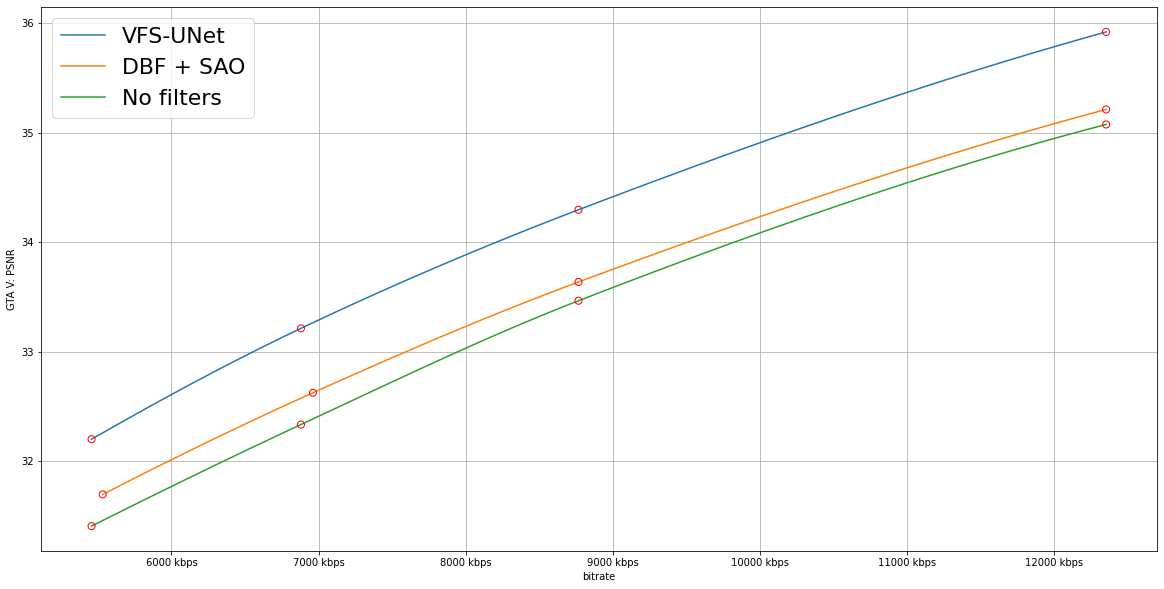

GTA V: PSNR: 0.6493972473381954
GTA V: PSNR BD-rate: -13.535491930482046


In [4]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V: PSNR",
    psnr
)

100%|██████████| 1564/1564 [00:13<00:00, 112.33it/s]


[tensor(0.9576, dtype=torch.float64), tensor(0.9661, dtype=torch.float64), tensor(0.9734, dtype=torch.float64), tensor(0.9814, dtype=torch.float64)]
[tensor(0.9502, dtype=torch.float64), tensor(0.9593, dtype=torch.float64), tensor(0.9677, dtype=torch.float64), tensor(0.9769, dtype=torch.float64)]
[tensor(0.9471, dtype=torch.float64), tensor(0.9567, dtype=torch.float64), tensor(0.9661, dtype=torch.float64), tensor(0.9760, dtype=torch.float64)]


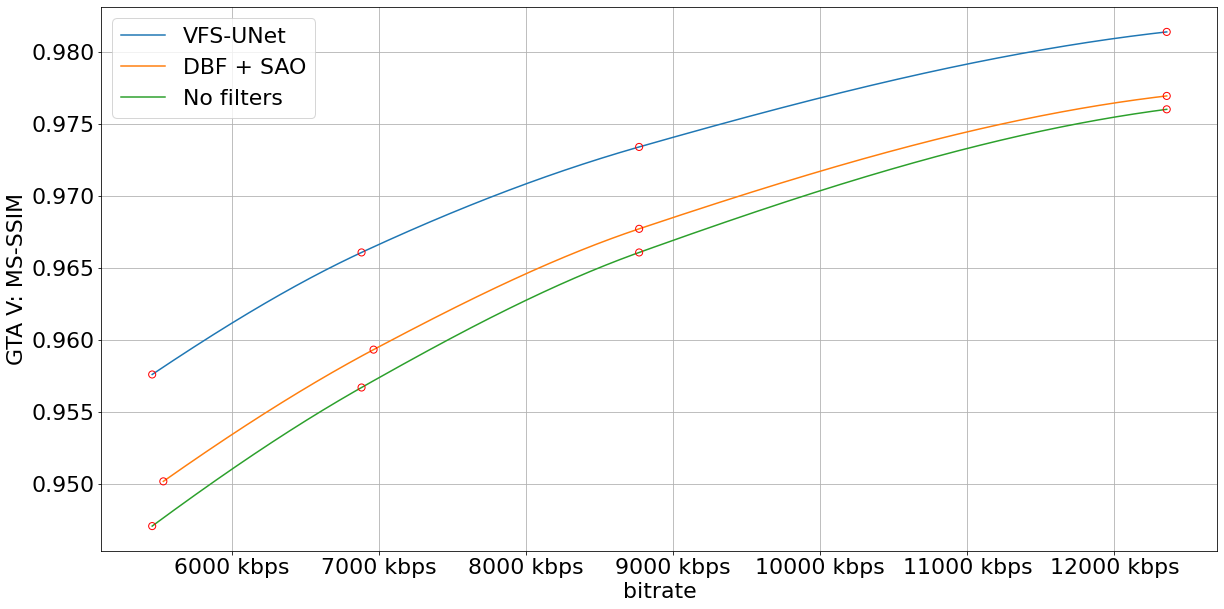

GTA V: MS-SSIM: 0.006115186572523428
GTA V: MS-SSIM BD-rate: -17.780010637221


In [5]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V: MS-SSIM",
    ms_ssim
)

100%|█████████▉| 12504/12505 [00:50<00:00, 249.66it/s]


[tensor(31.1828, dtype=torch.float64), tensor(32.1852, dtype=torch.float64), tensor(33.2396, dtype=torch.float64), tensor(34.7828, dtype=torch.float64)]
[tensor(30.5829, dtype=torch.float64), tensor(31.5304, dtype=torch.float64), tensor(32.5128, dtype=torch.float64), tensor(34.0217, dtype=torch.float64)]
[tensor(30.2837, dtype=torch.float64), tensor(31.2154, dtype=torch.float64), tensor(32.3846, dtype=torch.float64), tensor(33.9193, dtype=torch.float64)]


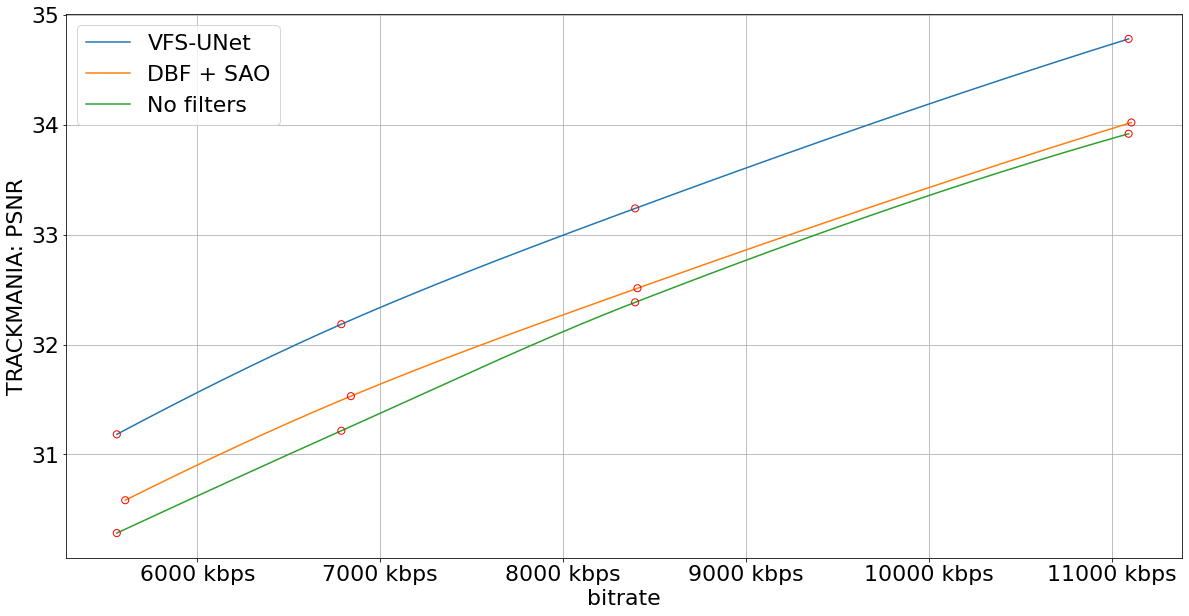

TRACKMANIA: PSNR: 0.7171279532219875
TRACKMANIA: PSNR BD-rate: -13.27170194349624


In [6]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA: PSNR",
    psnr
)

100%|█████████▉| 12504/12505 [01:44<00:00, 119.27it/s]


[tensor(0.9502, dtype=torch.float64), tensor(0.9534, dtype=torch.float64), tensor(0.9563, dtype=torch.float64), tensor(0.9596, dtype=torch.float64)]
[tensor(0.9420, dtype=torch.float64), tensor(0.9460, dtype=torch.float64), tensor(0.9502, dtype=torch.float64), tensor(0.9549, dtype=torch.float64)]
[tensor(0.9391, dtype=torch.float64), tensor(0.9434, dtype=torch.float64), tensor(0.9487, dtype=torch.float64), tensor(0.9539, dtype=torch.float64)]


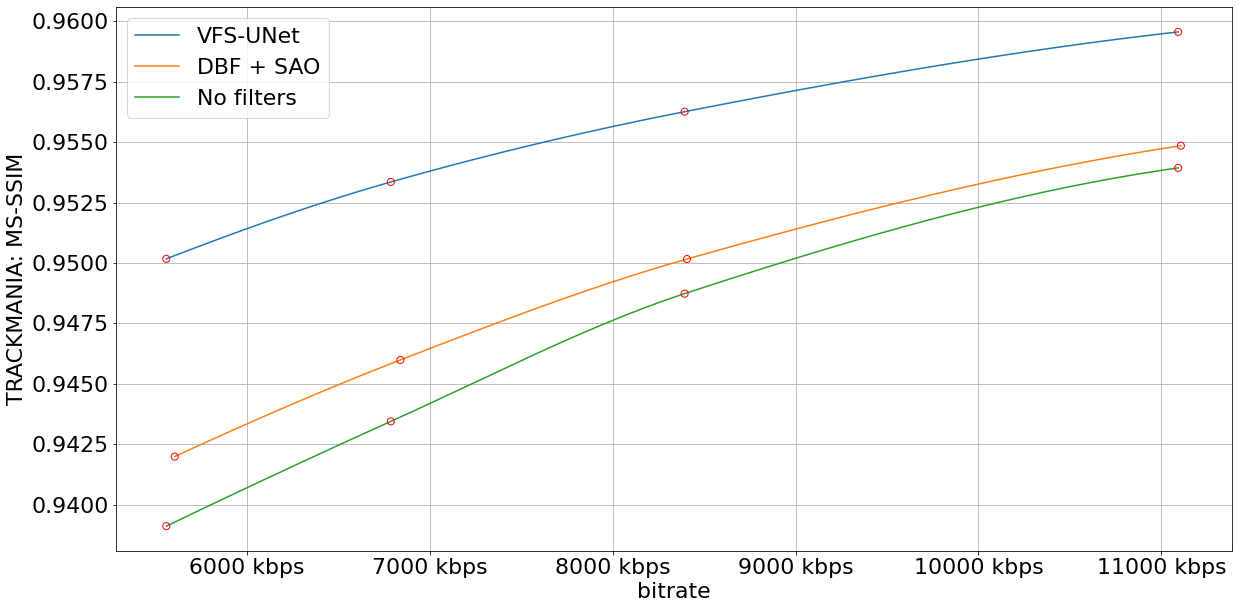

TRACKMANIA: MS-SSIM: 0.006538681578782094
TRACKMANIA: MS-SSIM BD-rate: -32.96631759823566


In [7]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA: MS-SSIM",
    ms_ssim
)

100%|██████████| 3483/3483 [00:12<00:00, 282.86it/s]


[tensor(32.2201, dtype=torch.float64), tensor(33.0180, dtype=torch.float64), tensor(34.2238, dtype=torch.float64), tensor(35.9114, dtype=torch.float64)]
[tensor(32.1159, dtype=torch.float64), tensor(32.9836, dtype=torch.float64), tensor(34.0275, dtype=torch.float64), tensor(35.5147, dtype=torch.float64)]
[tensor(31.9047, dtype=torch.float64), tensor(32.7580, dtype=torch.float64), tensor(33.9853, dtype=torch.float64), tensor(35.5288, dtype=torch.float64)]


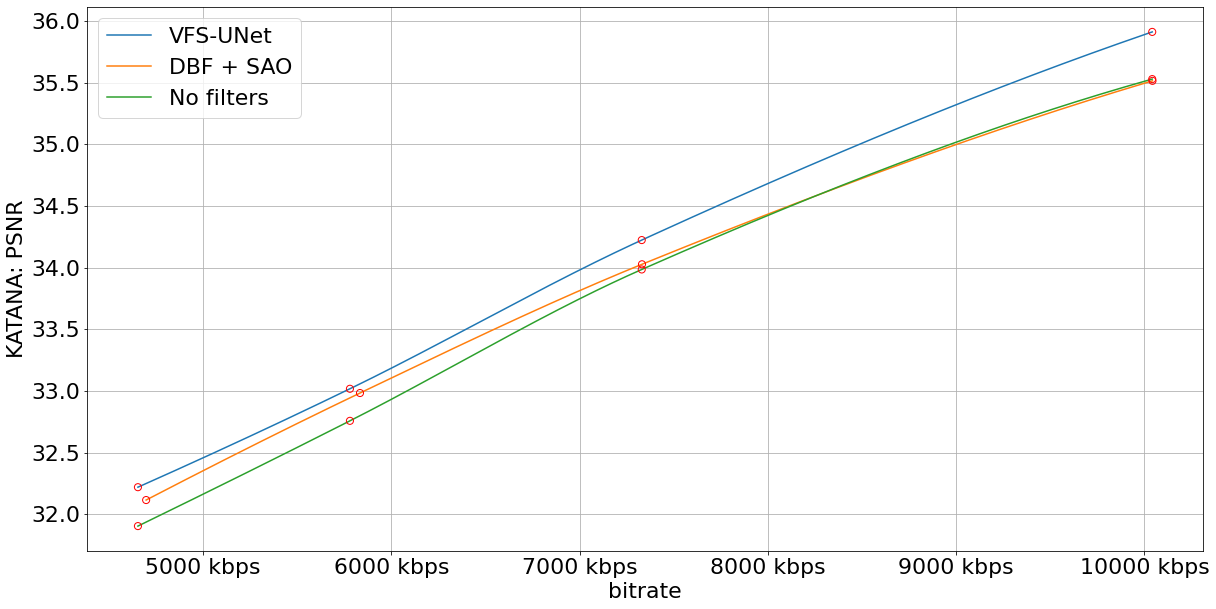

KATANA: PSNR: 0.18938318398350057
KATANA: PSNR BD-rate: -3.9332531116056613


In [8]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/katana-qp39"),
        torch.load("../trained_models/katana-qp37"),
        torch.load("../trained_models/katana-qp35"),
        torch.load("../trained_models/katana-qp32"),
    ],
    "KATANA: PSNR",
    psnr
)

100%|██████████| 3483/3483 [00:28<00:00, 122.58it/s]


[tensor(0.9496, dtype=torch.float64), tensor(0.9543, dtype=torch.float64), tensor(0.9598, dtype=torch.float64), tensor(0.9652, dtype=torch.float64)]
[tensor(0.9445, dtype=torch.float64), tensor(0.9502, dtype=torch.float64), tensor(0.9560, dtype=torch.float64), tensor(0.9620, dtype=torch.float64)]
[tensor(0.9432, dtype=torch.float64), tensor(0.9490, dtype=torch.float64), tensor(0.9554, dtype=torch.float64), tensor(0.9619, dtype=torch.float64)]


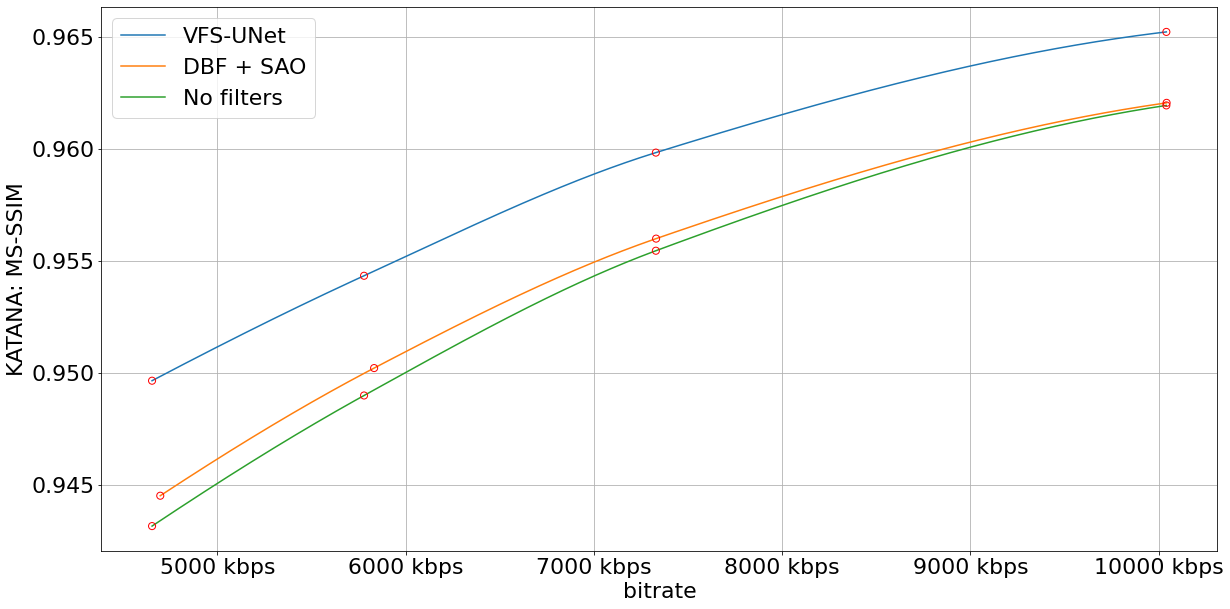

KATANA: MS-SSIM: 0.004049271776949023
KATANA: MS-SSIM BD-rate: -16.462036412833513


In [9]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/katana-qp39"),
        torch.load("../trained_models/katana-qp37"),
        torch.load("../trained_models/katana-qp35"),
        torch.load("../trained_models/katana-qp32"),
    ],
    "KATANA: MS-SSIM",
    ms_ssim
)

100%|██████████| 3483/3483 [00:11<00:00, 304.71it/s]


[tensor(31.8174, dtype=torch.float64), tensor(32.7175, dtype=torch.float64), tensor(33.7440, dtype=torch.float64), tensor(35.4032, dtype=torch.float64)]
[tensor(32.1159, dtype=torch.float64), tensor(32.9836, dtype=torch.float64), tensor(34.0275, dtype=torch.float64), tensor(35.5147, dtype=torch.float64)]
[tensor(31.9047, dtype=torch.float64), tensor(32.7580, dtype=torch.float64), tensor(33.9853, dtype=torch.float64), tensor(35.5288, dtype=torch.float64)]


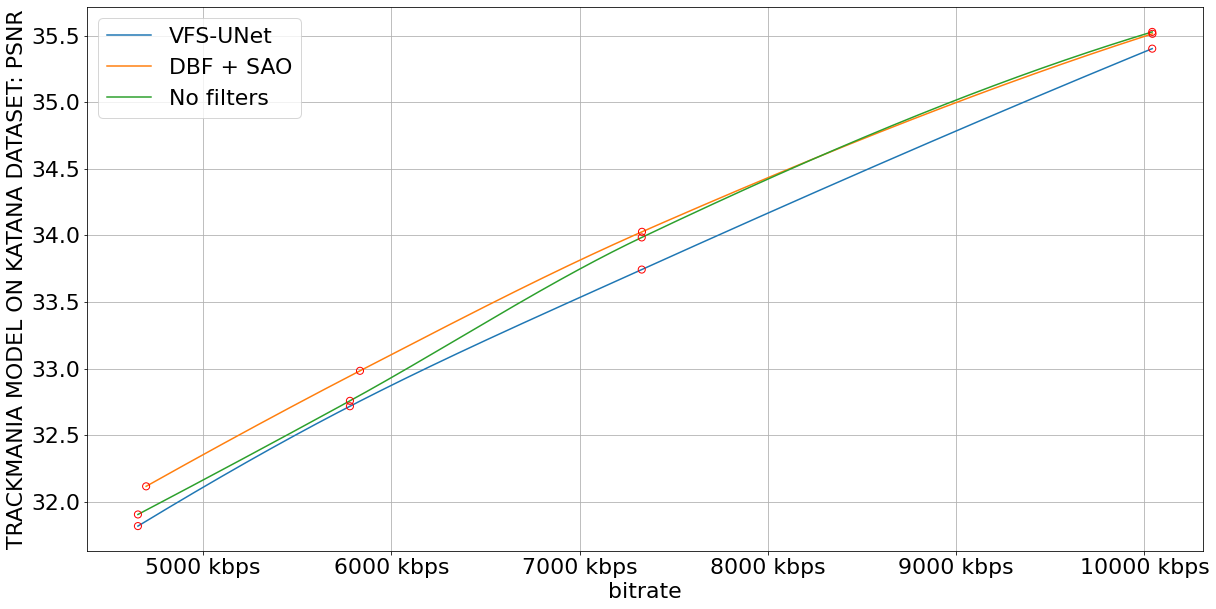

TRACKMANIA MODEL ON KATANA DATASET: PSNR: -0.24181409609492394
TRACKMANIA MODEL ON KATANA DATASET: PSNR BD-rate: 5.596312247239066


In [10]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA MODEL ON KATANA DATASET: PSNR",
    psnr
)

100%|██████████| 3483/3483 [00:28<00:00, 122.48it/s]


[tensor(0.9464, dtype=torch.float64), tensor(0.9517, dtype=torch.float64), tensor(0.9576, dtype=torch.float64), tensor(0.9634, dtype=torch.float64)]
[tensor(0.9445, dtype=torch.float64), tensor(0.9502, dtype=torch.float64), tensor(0.9560, dtype=torch.float64), tensor(0.9620, dtype=torch.float64)]
[tensor(0.9432, dtype=torch.float64), tensor(0.9490, dtype=torch.float64), tensor(0.9554, dtype=torch.float64), tensor(0.9619, dtype=torch.float64)]


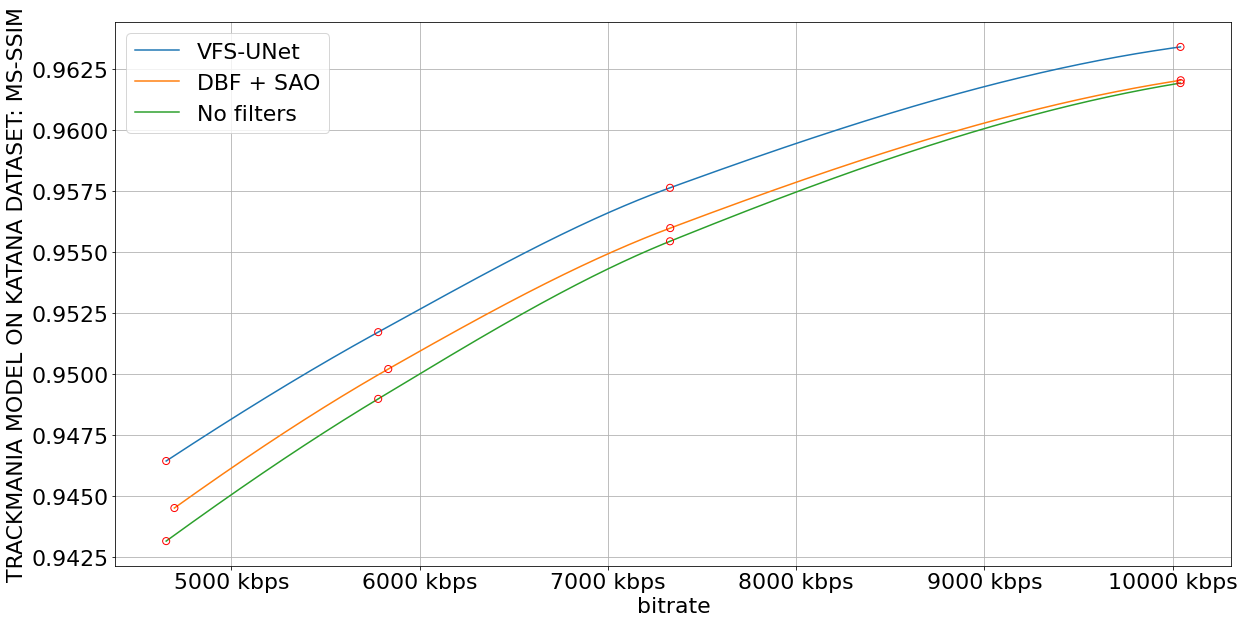

TRACKMANIA MODEL ON KATANA DATASET: MS-SSIM: 0.001697777188870235
TRACKMANIA MODEL ON KATANA DATASET: MS-SSIM BD-rate: -7.103929269681752


In [11]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA MODEL ON KATANA DATASET: MS-SSIM",
    ms_ssim
)

100%|█████████▉| 12504/12505 [00:48<00:00, 259.30it/s]


[tensor(30.7171, dtype=torch.float64), tensor(31.6741, dtype=torch.float64), tensor(32.7649, dtype=torch.float64), tensor(34.2931, dtype=torch.float64)]
[tensor(30.5829, dtype=torch.float64), tensor(31.5304, dtype=torch.float64), tensor(32.5128, dtype=torch.float64), tensor(34.0217, dtype=torch.float64)]
[tensor(30.2837, dtype=torch.float64), tensor(31.2154, dtype=torch.float64), tensor(32.3846, dtype=torch.float64), tensor(33.9193, dtype=torch.float64)]


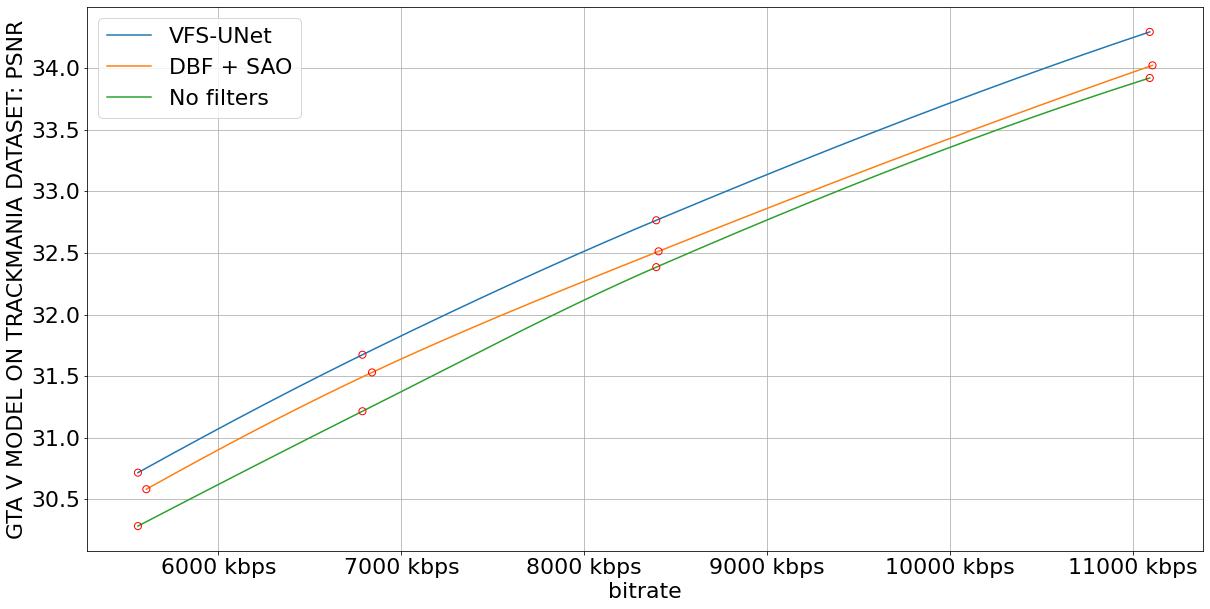

GTA V MODEL ON TRACKMANIA DATASET: PSNR: 0.23198085281812011
GTA V MODEL ON TRACKMANIA DATASET: PSNR BD-rate: -4.485186406045571


In [12]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V MODEL ON TRACKMANIA DATASET: PSNR",
    psnr
)

100%|█████████▉| 12504/12505 [01:44<00:00, 119.28it/s]


[tensor(0.9477, dtype=torch.float64), tensor(0.9510, dtype=torch.float64), tensor(0.9545, dtype=torch.float64), tensor(0.9583, dtype=torch.float64)]
[tensor(0.9420, dtype=torch.float64), tensor(0.9460, dtype=torch.float64), tensor(0.9502, dtype=torch.float64), tensor(0.9549, dtype=torch.float64)]
[tensor(0.9391, dtype=torch.float64), tensor(0.9434, dtype=torch.float64), tensor(0.9487, dtype=torch.float64), tensor(0.9539, dtype=torch.float64)]


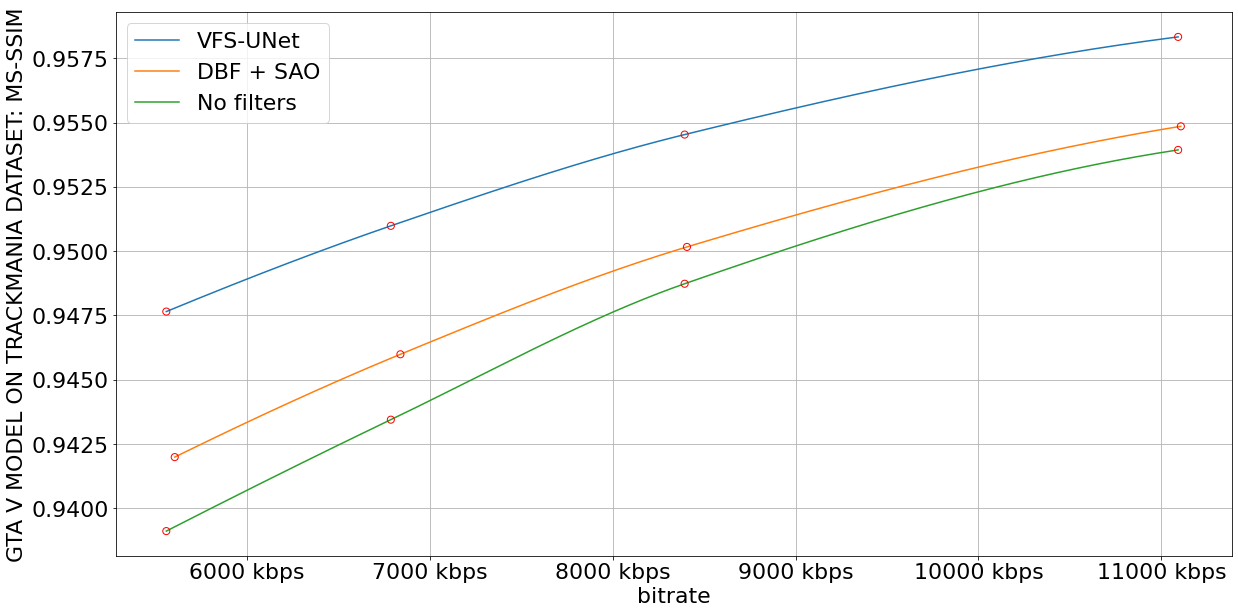

GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM: 0.004625175865665518
GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM BD-rate: -23.06565207642749


100%|█████████▉| 12504/12505 [01:45<00:00, 118.50it/s]


[tensor(0.9477, dtype=torch.float64), tensor(0.9510, dtype=torch.float64), tensor(0.9545, dtype=torch.float64), tensor(0.9583, dtype=torch.float64)]
[tensor(0.9420, dtype=torch.float64), tensor(0.9460, dtype=torch.float64), tensor(0.9502, dtype=torch.float64), tensor(0.9549, dtype=torch.float64)]
[tensor(0.9391, dtype=torch.float64), tensor(0.9434, dtype=torch.float64), tensor(0.9487, dtype=torch.float64), tensor(0.9539, dtype=torch.float64)]


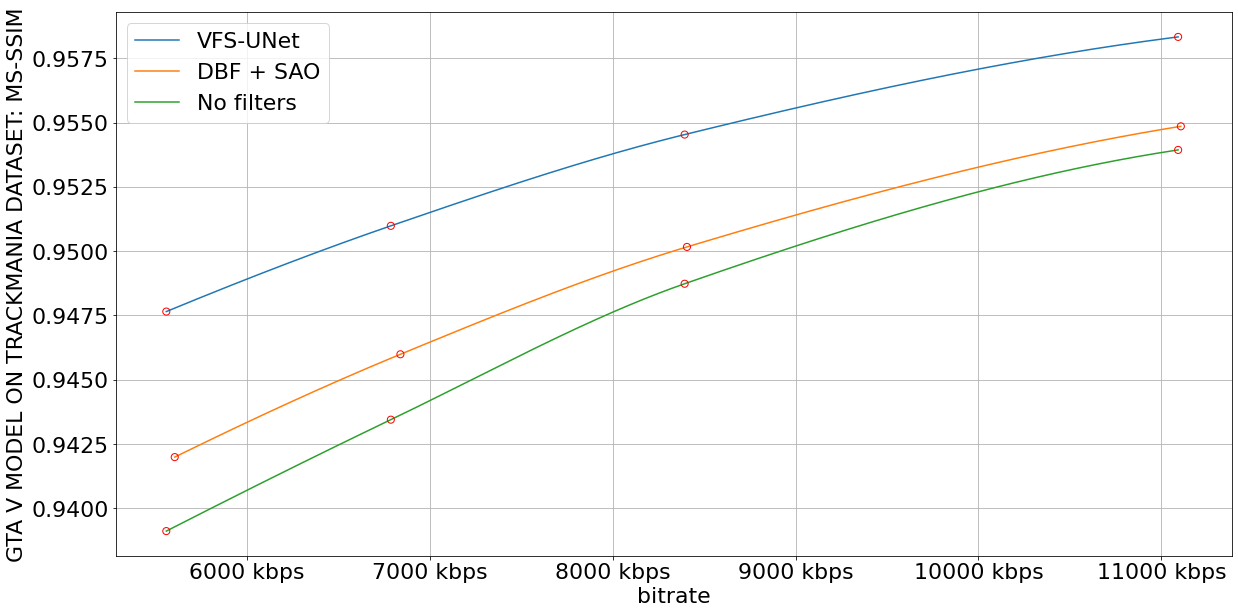

GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM: 0.004625175865665518
GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM BD-rate: -23.06565207642749


In [14]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM",
    ms_ssim
)